In [ ]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
data = pd.read_csv('data/256_images_np/data.csv')
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data.AcuteHF = data.AcuteHF.astype(int)
data.PNA = data.PNA.astype(int)
data.cardio_edema = data.cardio_edema.astype(int)
data.to_csv('data/256_images_np/data_fixed.csv', index=False)
data

,unique_key,bnpp,cardio_edema,bmi,cr,PNA,AcuteHF
0,Abachug_50267230_img1,418.0,1,25.51,0.61,1,0
1,Abadik_50217497_img1,2161.0,1,31.38,1.31,0,0
2,Abafouck_52403307_img1,118.0,0,33.81,0.66,0,0
3,Abagash_52691625_img1,49.9,0,30.64,0.64,0,0
4,Abakleem_50725934_img1,20029.0,1,34.81,10.54,0,0
...,...,...,...,...,...,...,...
16614,Zufosloo_50189474_img1,2988.0,1,44.06,1.29,0,1
16615,Zuliquep_52986445_img1,5684.0,1,26.07,0.50,0,1
16616,Zunakot_51932665_img1,123.0,0,22.73,0.94,0,0
16617,Zuplouke_51797661_img1,1290.0,1,27.66,1.77,0,0


100%|██████████| 16619/16619 [01:32<00:00, 180.32it/s]


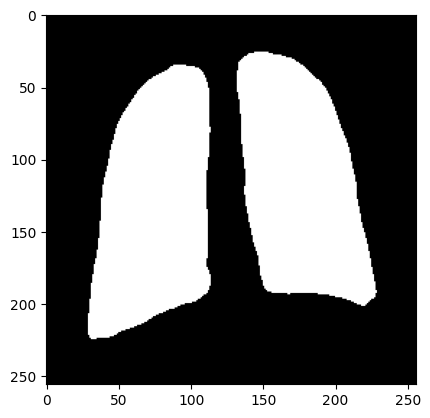

In [ ]:
# combining the left and right lung binary masks
masks = []
with h5py.File('seg_images_fixed.hdf5','r') as hf:
    for i in tqdm(range(hf['training_images'].shape[0])):
        mask1 = hf['training_images'][i,:,:,0]
        mask1 = np.where(mask1 >= 0.5, 1, 0)
        mask1 = mask1.reshape(256,256,1)
        mask2 = hf['training_images'][i,:,:,1]
        mask2 = np.where(mask2 >= 0.5, 1, 0)
        mask2 = mask2.reshape(256,256,1)
        mask = np.logical_or(mask1,mask2)
        masks.append(mask)
    hf.close()
masks = np.array(masks)
plt.imshow(masks[0],cmap='gray')
# f = h5py.File('rlung_masks.hdf5','w')
# f.create_dataset('training_images', data=masks)
# f.close()

(16619, 256, 256, 1)


100%|██████████| 16619/16619 [02:56<00:00, 93.98it/s] 


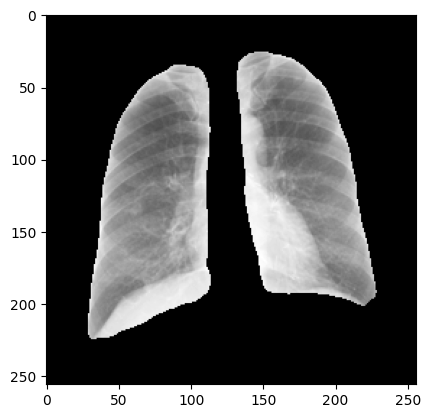

In [ ]:
#lung segmentation images
images = []
with h5py.File('images_fixed.hdf5','r') as hf:
    print(hf['training_images'].shape)
    for i in tqdm(range(hf['training_images'].shape[0])):
        images.append(hf['training_images'][i]*masks[i])
    hf.close()
images = np.array(images)
plt.imshow(images[0],cmap='gray')
f = h5py.File('final_lung_seg.hdf5','w')
f.create_dataset('training_images', data=images)
f.close()

100%|██████████| 16619/16619 [00:58<00:00, 281.84it/s]


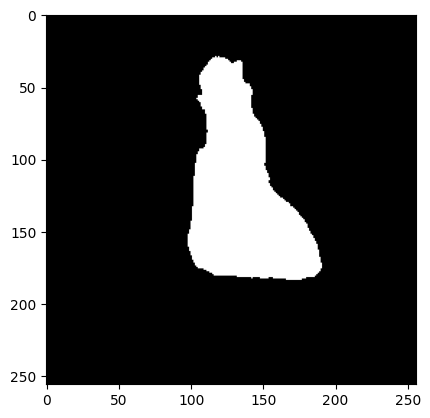

In [ ]:
#heart masks
masks = []
with h5py.File('seg_images_fixed.hdf5','r') as hf:
    for i in tqdm(range(hf['training_images'].shape[0])):
        mask = hf['training_images'][i,:,:,2]
        mask = np.where(mask >= 0.5, 1, 0)
        mask = mask.reshape(256,256,1)
        masks.append(mask)
    hf.close()
masks = np.array(masks)
plt.imshow(masks[0],cmap='gray')

(16619, 256, 256, 1)


100%|██████████| 16619/16619 [02:27<00:00, 112.31it/s]


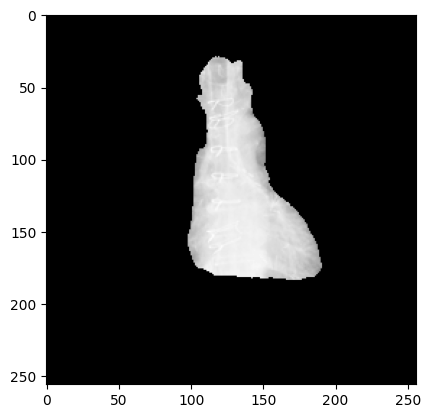

In [ ]:
#heart segmentation images
images = []
with h5py.File('images_fixed.hdf5','r') as hf:
    print(hf['training_images'].shape)
    for i in tqdm(range(hf['training_images'].shape[0])):
        images.append(hf['training_images'][i]*masks[i])
    hf.close()
images = np.array(images)
plt.imshow(images[0],cmap='gray')
f = h5py.File('final_heart_seg.hdf5','w')
f.create_dataset('training_images', data=images)
f.close()

In [ ]:
#now creating a final image dataset with the original image, lung segmentation, and heart segmentation
#called final.hdf5
#keys are 'original', 'lung_seg', and 'heart_seg'
try:
    final.close()
except:
    pass
import os
WORKING_DIR = os.getcwd()
final = h5py.File('final.hdf5', 'a')
original = h5py.File('images_fixed.hdf5', 'r')
final.create_dataset('original', data=original['training_images'])
original.close()
lung_seg = h5py.File('final_lung_seg.hdf5', 'r')
final.create_dataset('lung_seg', data=lung_seg['training_images'])
lung_seg.close()
heart_seg = h5py.File('final_heart_seg.hdf5', 'r')
final.create_dataset('heart_seg', data=heart_seg['training_images'])
heart_seg.close()
final.close()

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


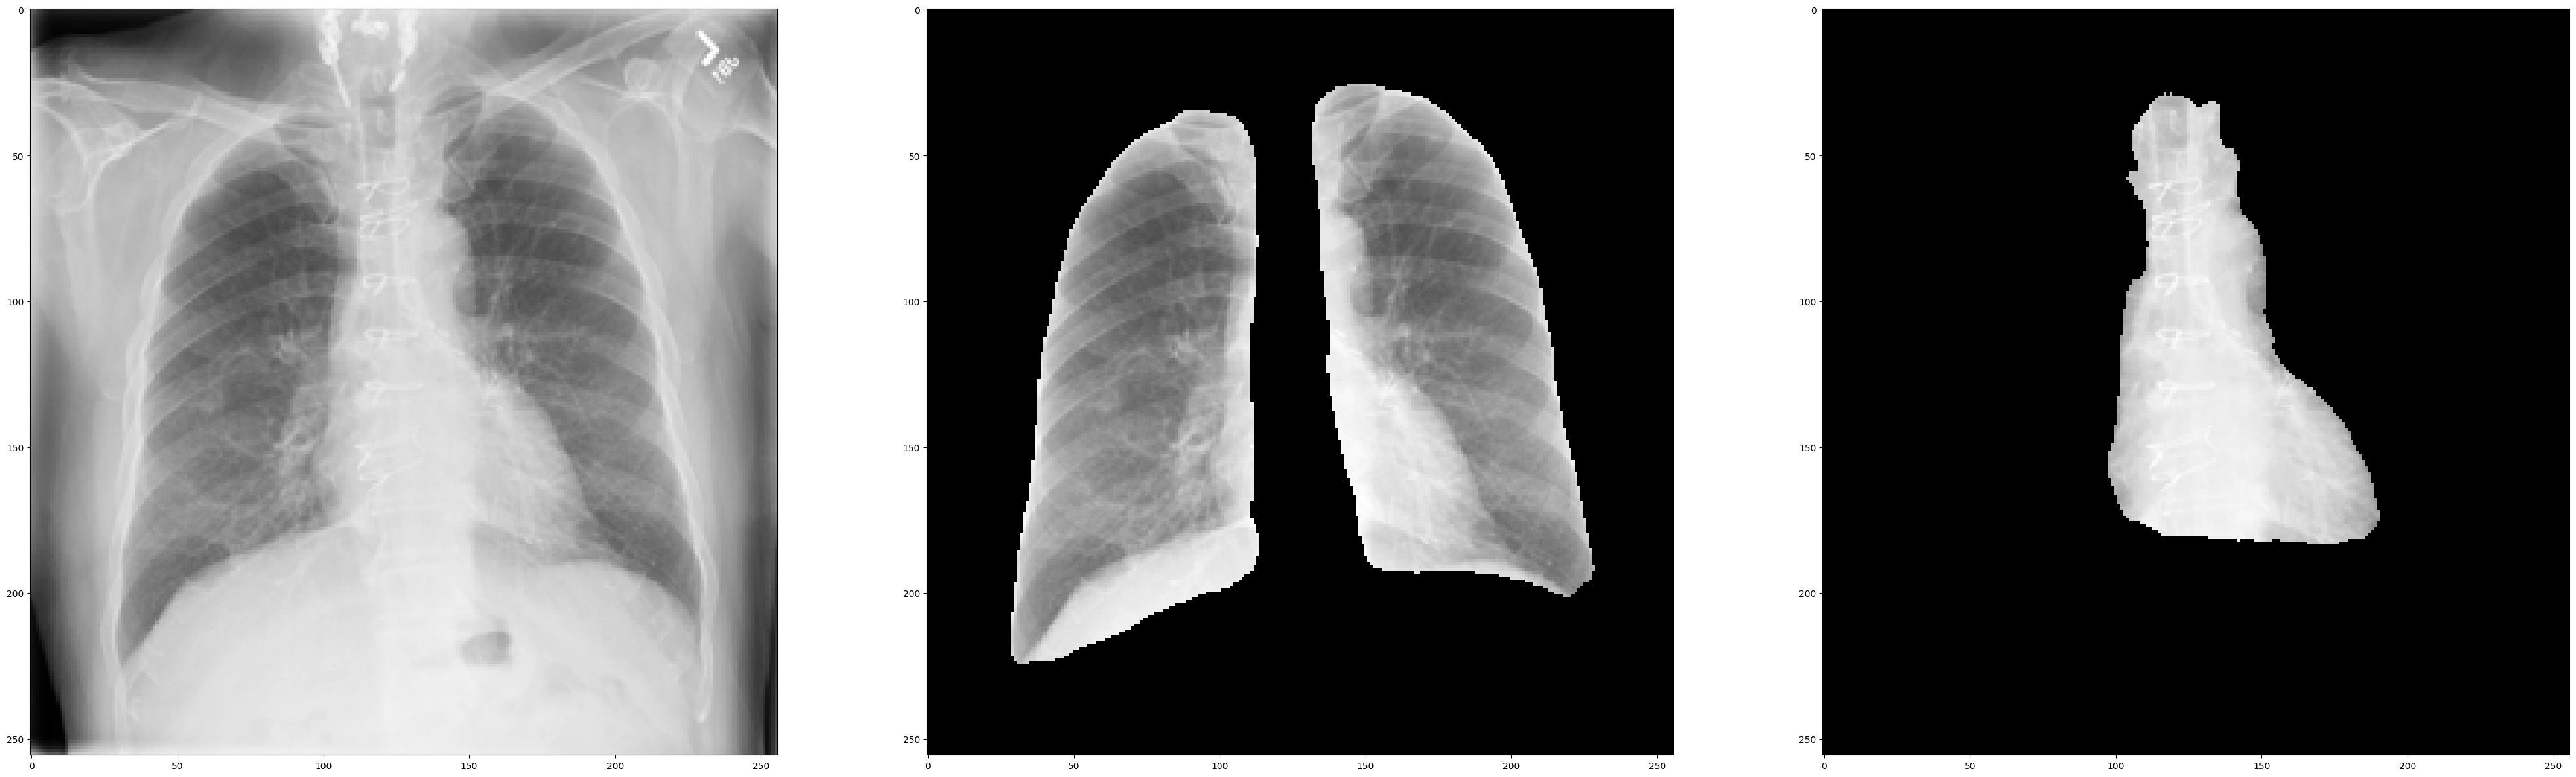

In [ ]:
final = h5py.File('final.hdf5', 'r')
fig, ax = plt.subplots(1, 3, figsize=(50, 50))
print(final['original'][0].shape)
ax[0].imshow(final['original'][0],cmap='gray')
print(final['lung_seg'][0].shape)
ax[1].imshow(final['lung_seg'][0],cmap='gray')
print(final['heart_seg'][0].shape)
ax[2].imshow(final['heart_seg'][0],cmap='gray')
final.close()

In [ ]:
#converting final.hdf5 to a single numpy array for ResNet input
#this is the data that will directly be used for training
#final.npy
import torch
final = h5py.File('final.hdf5', 'r')
images = []
for i in tqdm(range(final['original'].shape[0])):
    image = np.concatenate((final['original'][i], final['lung_seg'][i], final['heart_seg'][i]), axis=2)
    image = image.astype('float32')
    images.append(image)
print(images[0][0].dtype)
print(len(images))
#np.savez_compressed('final', images)
np.save('final.npy', images)
final.close()

100%|██████████| 16619/16619 [00:49<00:00, 339.03it/s]

float32
16619


In [ ]:
#checking to see if the data is correct for the ResNet input
images = np.load('final.npy')
print(images.shape)
plt.imshow(images[0])

## Stuff we didnt use below

100%|██████████| 16619/16619 [01:04<00:00, 258.77it/s]


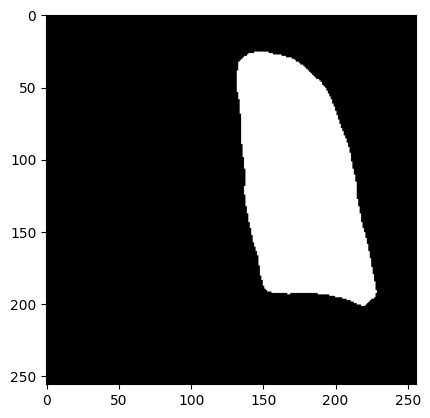

In [ ]:
#left lung masks (patients perspective)
masks = []
with h5py.File('seg_images_fixed.hdf5','r') as hf:
    for i in tqdm(range(hf['training_images'].shape[0])):
        mask = hf['training_images'][i,:,:,1]
        mask = np.where(mask >= 0.5, 1, 0)
        mask = mask.reshape(256,256,1)
        masks.append(mask)
    hf.close()
masks = np.array(masks)
plt.imshow(masks[0],cmap='gray')
# f = h5py.File('llung_masks.hdf5','w')
# f.create_dataset('training_images', data=masks)
# f.close()

In [ ]:
#left lung segmentation images (patients perspective)
images = []
with h5py.File('images_fixed.hdf5','r') as hf:
    print(hf['training_images'].shape)
    for i in tqdm(range(hf['training_images'].shape[0])):
        images.append(hf['training_images'][i]*masks[i])
    hf.close()
images = np.array(images)
plt.imshow(images[0],cmap='gray')
f = h5py.File('final_llung_seg.hdf5','w')
f.create_dataset('training_images', data=images)
f.close()

(16619, 256, 256, 1)


100%|██████████| 16619/16619 [02:38<00:00, 104.65it/s]


In [ ]:
with h5py.File('seg_images_fixed.hdf5','r') as hf:
    print(hf['training_images'].shape)
    plt.figure()
    plt.imshow(hf['training_images'][0,:,:,0],cmap='gray')
    plt.figure()
    plt.imshow(hf['training_images'][0,:,:,1],cmap='gray')
    plt.figure()
    plt.imshow(hf['training_images'][0,:,:,2],cmap='gray')
    plt.figure()
    mask1 = torch.from_numpy(hf['training_images'][0,:,:,0])
    #print(mask1)
    fixed_mask1 = np.where(mask1 >= 0.5, 1, 0)
    #print(np.sum(fixed_mask))
    #print(len(np.where(mask1[0]>=0.5)),len(np.where(mask1[1]>=0.5)))
    mask2 = torch.from_numpy(hf['training_images'][0,:,:,1])
    fixed_mask2 = np.where(mask2 >= 0.5, 1, 0)
    #print(mask2)
    mask3 = torch.from_numpy(hf['training_images'][0,:,:,2])
    fixed_mask3 = np.where(mask3 >= 0.5, 1, 0)
    #print(mask3)
    mask = torch.from_numpy(fixed_mask1).logical_or(torch.from_numpy(fixed_mask2)).logical_or(torch.from_numpy(fixed_mask3))
    print(mask)
    plt.imshow(mask,cmap='gray')
    hf.close()

(16619, 256, 256, 6)


100%|██████████| 16619/16619 [02:37<00:00, 105.34it/s]


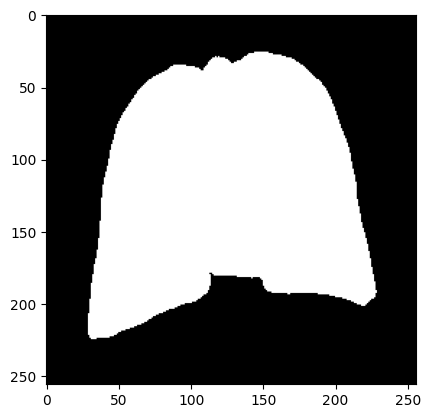

In [ ]:
masks = []
with h5py.File('seg_images_fixed.hdf5','r') as hf:
    print(hf['training_images'].shape)
    for i in tqdm(range(hf['training_images'].shape[0])):
    
        mask1 = hf['training_images'][i,:,:,0]
        fixed_mask1 = np.where(mask1 >= 0.5, 1, 0)
        mask2 = hf['training_images'][i,:,:,1]
        fixed_mask2 = np.where(mask2 >= 0.5, 1, 0)
        mask3 = hf['training_images'][i,:,:,2]
        fixed_mask3 = np.where(mask3 >= 0.5, 1, 0)
        mask = np.logical_or(fixed_mask1,fixed_mask2)
        mask = np.logical_or(mask,fixed_mask3)
        mask = mask.reshape(256,256,1)
        #print(mask.shape)
        #plt.imshow(mask,cmap='gray')
        masks.append(mask)
    hf.close()
masks = np.array(masks)
plt.imshow(masks[0],cmap='gray')
f = h5py.File('mask_images_fixed.hdf5','w')
f.create_dataset('training_images', data=masks)
f.close()

(16619, 256, 256, 1)


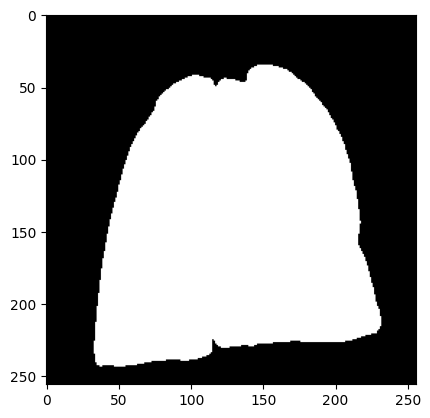

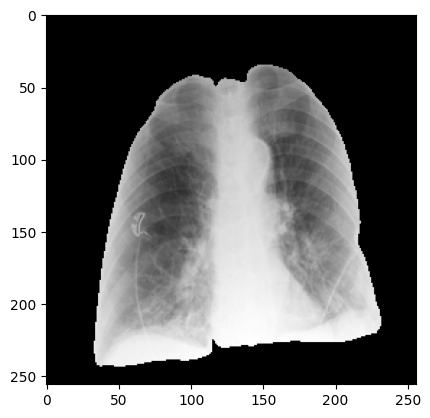

In [ ]:
plt.imshow(masks[1000],cmap='gray')
with h5py.File('images_fixed.hdf5','r') as hf2:
    print(hf2['training_images'].shape)
    plt.figure()
    hf2['training_images'][1000]*masks[1000]
    hf2.close()

(16619, 256, 256, 1)


100%|██████████| 16619/16619 [02:58<00:00, 92.93it/s] 


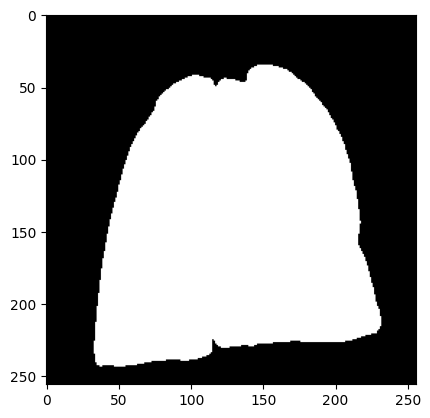

In [ ]:
plt.imshow(masks[1000],cmap='gray')
images = []
with h5py.File('images_fixed.hdf5','r') as hf2:
    print(hf2['training_images'].shape)
    for i in tqdm(range(hf2['training_images'].shape[0])):
        images.append(hf2['training_images'][i]*masks[i])
    hf2.close()
images = np.array(images)

In [ ]:
f = h5py.File('D:/Downloads/final_seg_images.hdf5','w')
f.create_dataset('training_images', data=images)
f.close()

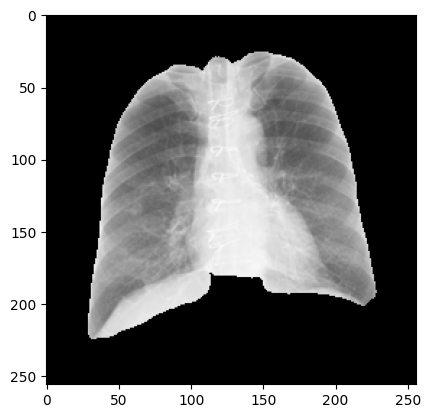

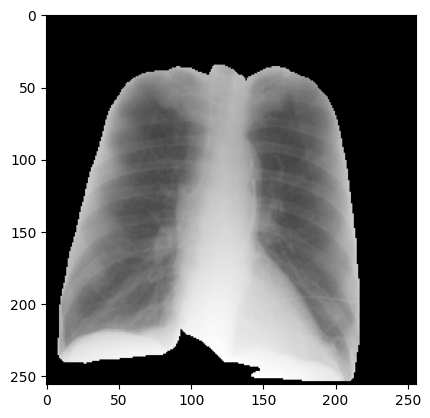

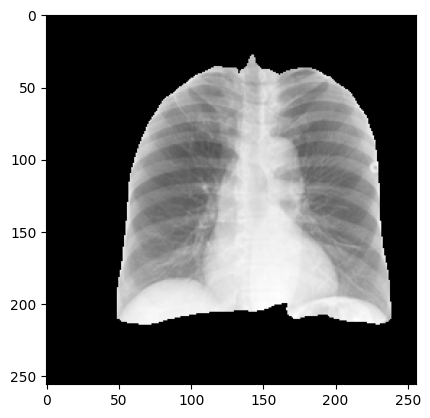

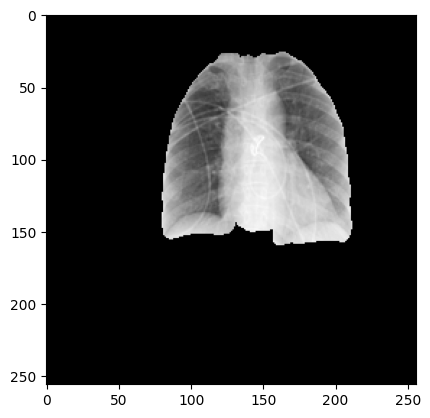

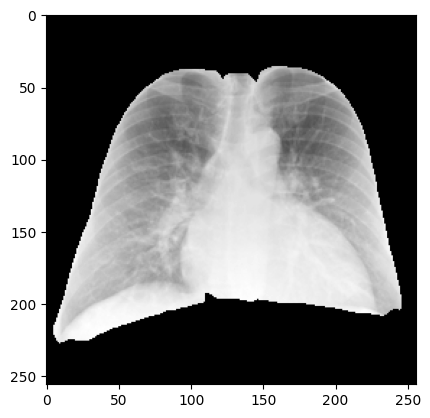

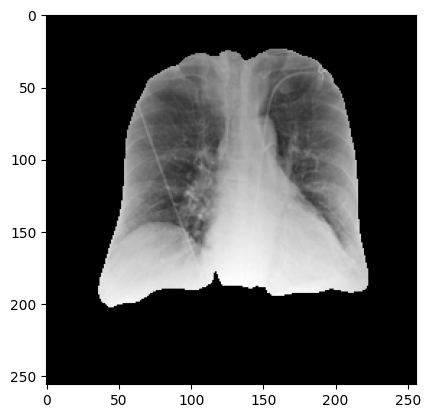

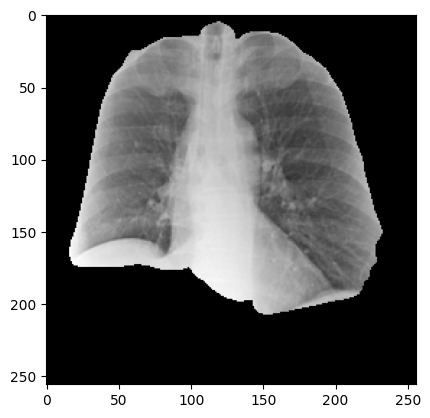

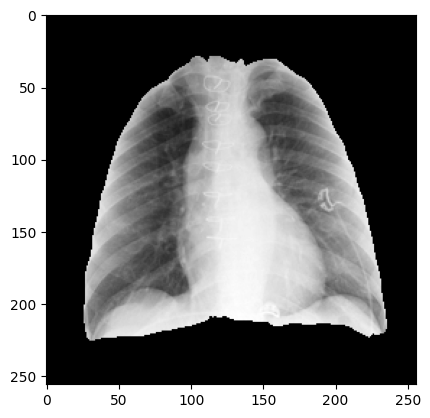

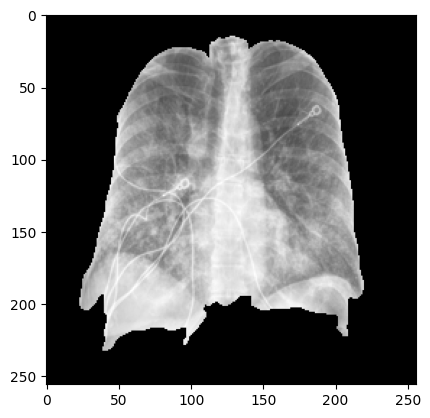

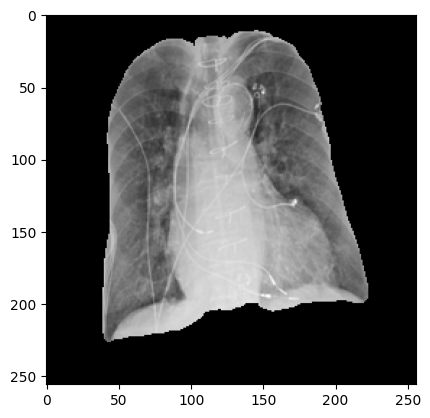

In [ ]:
f = h5py.File('D:/Downloads/final_seg_images.hdf5','r')
for i in range(10):
    plt.figure()
    plt.imshow(f['training_images'][i],cmap='gray')
#plt.imshow(f['training_images'][10000],cmap='gray')
f.close()